# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - \alpha (\left[\frac{1}{n}\sum_{i=1}^{n}2(\langle\,x_i,w_{old}\rangle - y_{i})x_i\right] + 2\frac{w_{old}}{C})$$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

градиент представляет собой усреднённую взвешенную ошибку на рассматриваемых n объектах, к которой добавили "обвес"

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - \alpha(\left[-\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\sigma{(\langle\,x_i,w_{old}\rangle)})x_i\right] + 2\frac{w_{old}}{C}) $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

***Ваше решение здесь***

Градиент представляет собой усредненную ошибку оценки вероятностей для рассматриваемых n объектов.В задаче лин. регрессии ошибка-разность предсказанного значения вещ. переменной и истинного.В данном случае ошибка-"остаток" вероятности.В остальном формулы совпадают

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

***Ваше решение здесь***

Первый пункт:
$$\nabla_{w}{Q(w)=(2X^{T}X)w-2X^{T}Y}=\left( \begin{array}{ccc}
\frac{\partial Q(w)}{\partial w_1} \\
\vdots \\
\frac{\partial Q(w)}{\partial w_n}
\end{array}\right)$$
$$\nabla{(\nabla_{w}{Q(w))^{T}}}=
\left( \begin{array}{ccc}
\frac{\partial^{2} Q(w)}{\partial w_{1}\partial w_{1}} & \ldots & \frac{\partial^{2} Q(w)}{\partial w_{n}\partial w_{1}}\\ 
\vdots & \ddots & \ldots \\ 
\frac{\partial^{2} Q(w)}{\partial w_{1}\partial w_{n}} & \ldots & \frac{\partial^{2} Q(w)}{\partial w_{n}\partial w_{n}}
\end{array}\right)=
\nabla_{w}{(w^{T}(2X^{T}X)-2Y^{T}X)}=2X^{T}X$$
$$\forall w:\langle 2X^TXw,w \rangle=2\langle Xw, Xw \rangle\gt0$$

Точное решение L2-регрессии:
$$w=(X^{T}X+\frac{1}{C}E)^{-1}X^{T}Y$$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$E(L|x_i)=-p(y_i=1|x_i)\log a(x_i)-(1-p(y_i=1|x_i))\log (1-a(x_i))$$
Найдем производную:
$$-\frac{\partial E}{\partial a(x_i)}=\frac{p(y_i=1|x_i)}{a(x_i)} - \frac{1-p(y_i=1|x_i)}{1-a(x_i)}=p(y_i=1|x_i)(\frac{1}{a(x_i)}+\frac{1}{1-a(x_i)})-\frac{1}{1-a(x_i)}=0$$
$$p(y_i=1|x_i)(\frac{1-a(x_i)}{a(x_i)}+1)=1p(y_i=1|x_i)=a(x_i)$$
Знак производной в этой точке меняется.Значит,это точка минимума

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [134]:
#%%pycodestyle
def batch_generator(X, y, shuffle=True, batch_size=100):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y          - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    X_batch = ""
    y_batch = ""
    indexes = np.arange(y.shape[0])
    num_iterations = y.shape[0] // batch_size
    for i in range(num_iterations):
        index_perm = np.random.permutation(indexes)[:batch_size] \
            if shuffle \
            else indexes[i: i + batch_size]
        X_batch = X[index_perm]
        y_batch = y[index_perm]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [146]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    # Your code Here
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)


sigmoid_vec = np.vectorize(sigmoid)


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(
        self,
        batch_generator,
        C=1,
        alpha=0.01,
        max_epoch=10,
        model_type='lin_reg',
        batch_size=10
    ):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            outp = (np.dot(X_batch, self.weights) - y_batch) ** 2
            return np.mean(outp) + np.sum(self.weights ** 2) / self.C
        else:
            sigma_outp = sigmoid_vec(np.dot(X_batch, self.weights))
            return - np.mean(y_batch * np.log(sigma_outp + 0.0001) +
                             (1 - y_batch) * np.log(1 - sigma_outp + 0.0001))
        + np.sum(self.weights ** 2) / self.C

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу(то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            prod = np.dot(X_batch, self.weights)
            return np.mean(
                X_batch * 2 * (prod - y_batch).reshape(-1, 1),
                axis=0
            ) + 2 * self.weights / self.C
        else:
            outp = sigmoid_vec(np.dot(X_batch, self.weights))
            return - np.mean(
                X_batch * (y_batch - outp).reshape(-1, 1),
                axis=0
            ) + 2 * self.weights / self.C

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        self.X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)),
                                axis=1).astype(np.float128)
        # Нужно инициализровать случайно вес
        self.weights = np.random.randn(X.shape[1] + 1).astype(np.float128)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(
                self.X,
                y,
                batch_size=self.batch_size
            )
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку
                # для отладки модели
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X_con = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)
        # Желательно здесь использовать матричные операции
        # между X и весами, например, numpy.dot
        if self.model_type == 'lin_reg':
            return np.dot(X_con, self.weights)
        else:
            return (sigmoid_vec(np.dot(X_con, self.weights)))

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

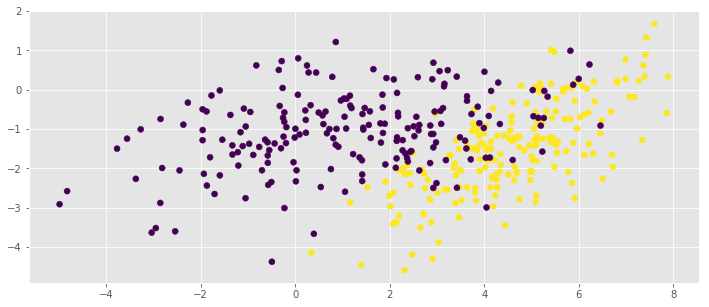

In [5]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

#plot_decision_boundary(model)

plt.scatter(X[:,0], X[:,1], c=y)

In [14]:
log_model = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=100, C=100, alpha=0.01, batch_size=10)

In [15]:
log_model.fit(X, y)

MySGDClassifier(C=100, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f8854206d08>,
        batch_size=10, max_epoch=100, model_type='log_reg')

In [42]:
lin_model = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=1, alpha=0.01, batch_size=10)

In [43]:
lin_model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f8854206d08>,
        batch_size=10, max_epoch=100, model_type='lin_reg')

# Веса:

In [44]:
lin_model.weights

array([ 0.13023241, -0.090758077,  0.011885113], dtype=float128)

In [19]:
log_model.weights

array([ 0.58862434, -0.42805554, -2.0685276], dtype=float128)

In [20]:
fpr, tpr, thr = metrics.roc_curve(y, log_model.predict(X))
accs = np.array([accuracy_score(y, log_model.predict(X) > t) for t in thr])
optimal_idx = np.nanargmax(accs)
optimal_thr = thr[optimal_idx]
accuracy_score(y, log_model.predict(X) > optimal_thr)

0.88249999999999995

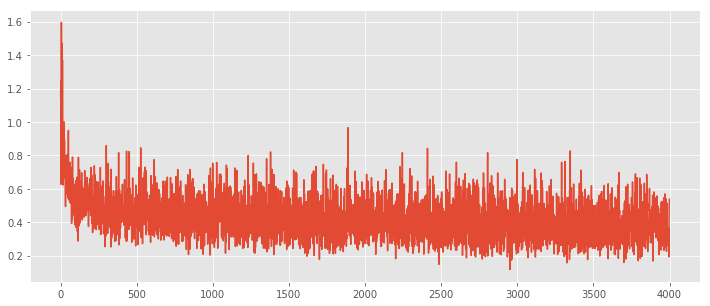

In [21]:
fig = plt.figure()
ax = plt.plot(log_model.errors_log['loss'])

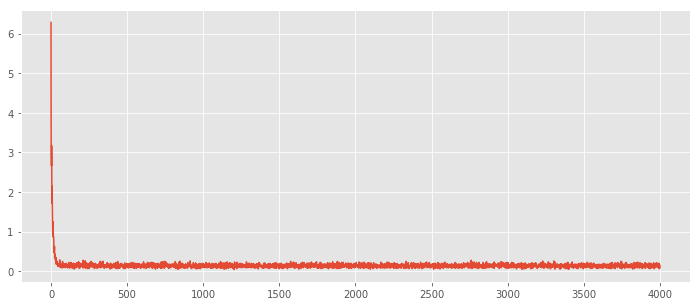

In [45]:
fig = plt.figure()
ax = plt.plot(lin_model.errors_log['loss'])

# разделяющие границы:

In [46]:
lin_model.weights[2]

0.011885113082927801487

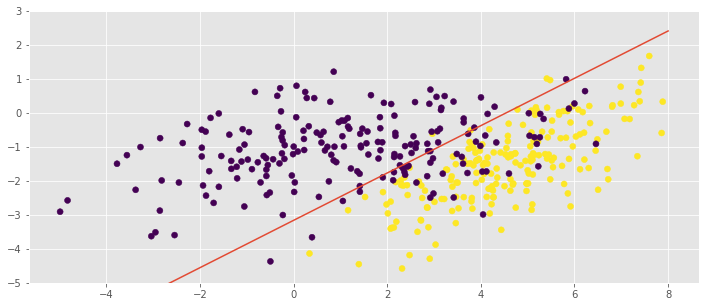

In [49]:
f, ax = plt.subplots(figsize=(12, 5))
#ax.contour(xx, yy, probs, 2, cmap="RdBu")
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_ylim([-5, 3])
ax.plot(np.linspace(-5, 8, 100), (- lin_model.weights[1] * np.linspace(-5, 8, 100) - lin_model.weights[2] - 0.4) / lin_model.weights[0] )

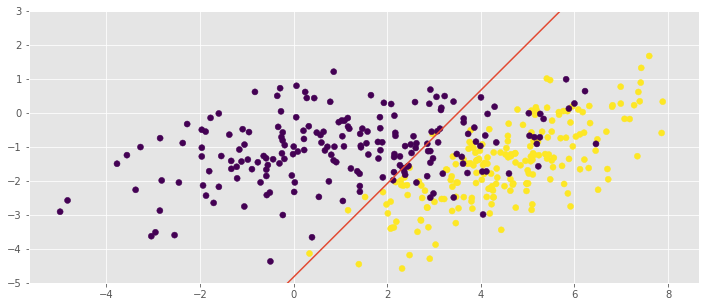

In [25]:
f, ax = plt.subplots(figsize=(12, 5))
#ax.contour(xx, yy, probs, 2, cmap="RdBu")
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_ylim([-5, 3])
ax.plot(np.linspace(-5, 8, 100), (- log_model.weights[0] * np.linspace(-5, 8, 100) - log_model.weights[2] ) / log_model.weights[1])

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [50]:
from sklearn.datasets import make_classification

In [51]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

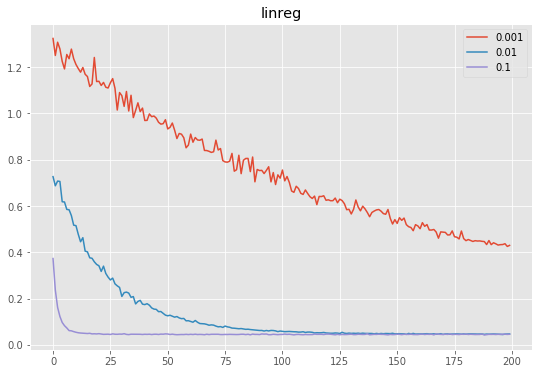

In [52]:
f, ax = plt.subplots(figsize=(9, 6))
N = 10
for alpha in np.logspace(-3, -1, 3):
    model_for_plot = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=20, C=100, alpha=alpha, batch_size=1000)
    model_for_plot.fit(X, y)
    points = np.mean(np.array(model_for_plot.errors_log['loss']).reshape(N, -1), axis=0)
    plt.plot(points, label=alpha)
plt.legend()
plt.title("linreg")

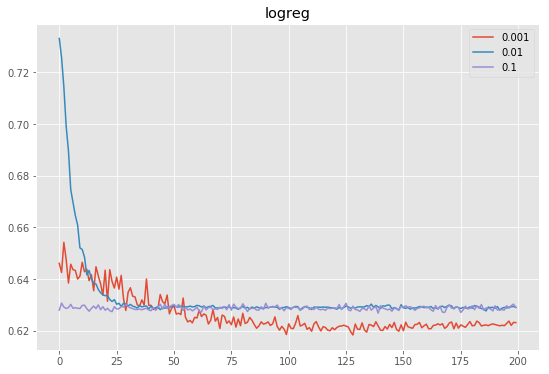

In [53]:
f, ax = plt.subplots(figsize=(9, 6))
N = 10
for alpha in np.logspace(-3, -1, 3):
    model_for_plot = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=20, C=0.2, alpha=alpha, batch_size=1000)
    model_for_plot.fit(X, y)
    points = np.mean(np.array(model_for_plot.errors_log['loss']).reshape(N, -1), axis=0)
    plt.plot(points, label=alpha)
plt.legend()
plt.title("logreg")

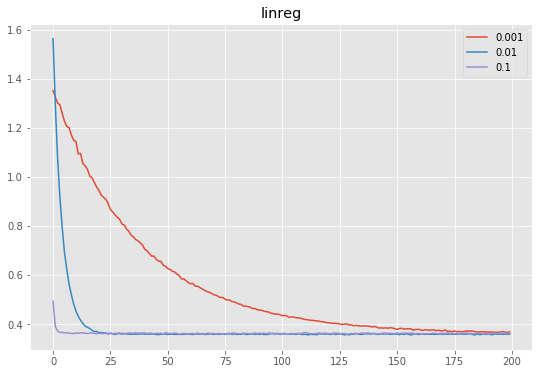

In [54]:
f, ax = plt.subplots(figsize=(9, 6))
N = 50
for alpha in np.logspace(-3, -1, 3):
    model_for_plot = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=0.2, alpha=alpha, batch_size=1000)
    model_for_plot.fit(X, y)
    points = np.mean(np.array(model_for_plot.errors_log['loss']).reshape(N, -1), axis=0)
    plt.plot(points, label=alpha)
plt.legend()
plt.title("linreg")

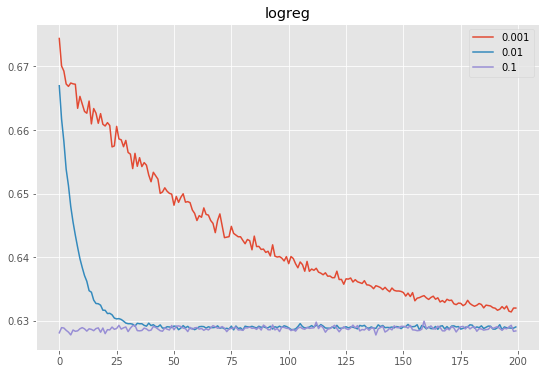

In [69]:
f, ax = plt.subplots(figsize=(9, 6))
N = 50
for alpha in np.logspace(-3, -1, 3):
    model_for_plot = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=100, C=0.2, alpha=alpha, batch_size=1000)
    model_for_plot.fit(X, y)
    points = np.mean(np.array(model_for_plot.errors_log['loss']).reshape(N, -1), axis=0)
    plt.plot(points, label=alpha)
plt.legend()
plt.title("logreg")

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

При alpha >= 1 сходимости нет.Наиболее стабильная сходимость при alpha порядка 0.1-0.01.
При alpha ~ 0.001 и меньше сходимость очень медленная, однако модель с таким learning rate может в более глубокую ямку и надёжно в ней обосноваться.Я считаю,что learning rate со временем должен изменяться.Начальное значение можно брать порядка 0.1-0.01 и уменьшать со временем.Возможно,стоит использовать более хитрые алгоритмы оптимизации:adagrad, adam.

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [57]:
points = []
for C in np.logspace(3, -3, 10):
    model_for_plot = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=1, C=C, alpha=0.01, batch_size=100)
    model_for_plot.fit(X, y)
    points.append(model_for_plot.weights)

In [58]:
points = np.array(points)

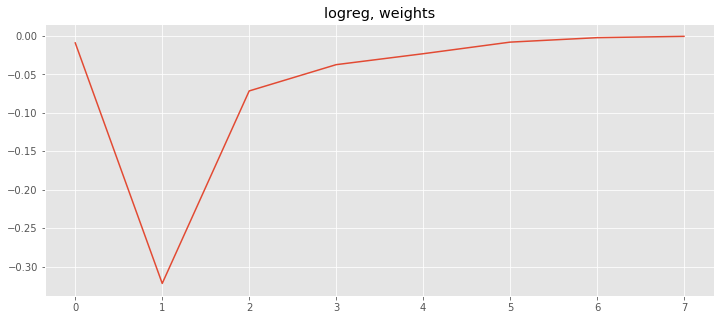

In [59]:
plt.plot(np.mean(points, axis=1))
plt.title("logreg, weights")

In [66]:
points = []
for C in np.logspace(3, -3, 10):
    model_for_plot = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=5, C=C, alpha=0.0001, batch_size=1000)
    model_for_plot.fit(X, y)
    points.append(model_for_plot.weights)

In [67]:
points = np.array(points)

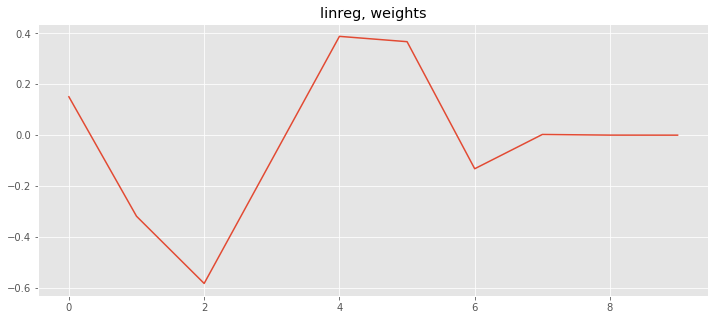

In [68]:
plt.plot(np.mean(points, axis=1))
plt.title("linreg, weights")

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Да,я доволен уменьшением весов.Насколько я понял,при выборе C необходимо ориентироваться на alpha и следить,чтобы alpha / C было маленьким,иначе влияние регуляризатора будет слишком сильным. 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [79]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [80]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [81]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


In [82]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [83]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [84]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [85]:
train_scaler = StandardScaler()
train_scaler.fit(X_train)
X_train_scaled = train_scaler.transform(X_train)
test_scaler = StandardScaler()
test_scaler.fit(X_test)
X_test_scaled = test_scaler.transform(X_test)

/home/abi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [86]:
kaggle_log_model = MySGDClassifier(batch_generator, C=0.1, model_type='log_reg', batch_size=1000, alpha=0.01, max_epoch=100)

In [87]:
kaggle_log_model.fit(X_train_scaled, y_train)

MySGDClassifier(C=0.1, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f4d1ac2b2f0>,
        batch_size=1000, max_epoch=100, model_type='log_reg')

In [95]:
precision, recall, thr = metrics.precision_recall_curve(y_train, kaggle_log_model.predict(X_train_scaled))
opt_idx = np.nanargmax(2 * (precision * recall) / (precision + recall))
opt_thr = thr[opt_idx]
f1_score(y_train, kaggle_log_model.predict(X_train_scaled) > opt_thr)

/home/abi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.61933774834437083

In [96]:
kaggle_lin_model = MySGDClassifier(batch_generator, C=0.1, model_type='lin_reg', batch_size=100, alpha=0.01)

In [97]:
kaggle_lin_model.fit(X_train_scaled, y_train)

MySGDClassifier(C=0.1, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f4d1ac2b2f0>,
        batch_size=100, max_epoch=10, model_type='lin_reg')

In [98]:
precision, recall, thr = metrics.precision_recall_curve(y_train, kaggle_lin_model.predict(X_train_scaled))
opt_idx = np.nanargmax(2 * (precision * recall) / (precision + recall))
opt_thr = thr[opt_idx]
f1_score(y_train, kaggle_lin_model.predict(X_train_scaled) > opt_thr)

/home/abi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.61853761734761337

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [125]:
def make_submission(prediction):
    sub = pd.DataFrame({'target': prediction,'pair_id': test_data['pair_id']})
    sub.to_csv("submission.csv", index=False)

In [99]:
indexes = np.arange(1, 130)

In [100]:
perm = np.random.permutation(indexes)

In [101]:
train_groups, valid_groups = perm[:104], perm[104:]

In [102]:
X_train_sets = X_train_scaled[np.isin(groups_train, train_groups)]
y_train_sets = y_train[np.isin(groups_train, train_groups)]
X_valid_sets = X_train_scaled[np.isin(groups_train, valid_groups)]
y_valid_sets = y_train[np.isin(groups_train, valid_groups)]

In [111]:
param_grid = {
    'batch_generator': [batch_generator],
    'C': [1, 0.1],
    'alpha': [0.1, 0.01, 0.001],
    'model_type': ['log_reg', 'lin_reg'],
    'max_epoch': [10, 50, 100],
    'batch_size': [1000]
}

grid = ParameterGrid(param_grid)

In [112]:
scores = []
for params in grid:
    clf = MySGDClassifier(**params)
    clf.fit(X_train_sets, y_train_sets)
    precision, recall, thr = metrics.precision_recall_curve(y_train_sets, clf.predict(X_train_sets))
    opt_idx = np.nanargmax(2 * (precision * recall) / (precision + recall))
    opt_thr = thr[opt_idx]
    scores.append({'score':f1_score(y_valid_sets, clf.predict(X_valid_sets) > opt_thr),
                  'params': params, 'thr': opt_thr})
np.argmax(map(lambda x: x['scores'], scores))

/home/abi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


0

In [120]:
final_clf = MySGDClassifier(**scores[0]['params'])

In [121]:
final_clf.fit(X_train_sets, y_train_sets)

MySGDClassifier(C=1, alpha=0.1,
        batch_generator=<function batch_generator at 0x7f4d1ac2b2f0>,
        batch_size=1000, max_epoch=10, model_type='log_reg')

In [122]:
precision, recall, thr = metrics.precision_recall_curve(y_train_sets, final_clf.predict(X_train_sets))
opt_idx = np.nanargmax(2 * (precision * recall) / (precision + recall))
opt_thr = thr[opt_idx]

/home/abi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [123]:
f1_score(y_train_sets, final_clf.predict(X_train_sets) > opt_thr)

0.62917398945518455

In [124]:
f1_score(y_valid_sets, final_clf.predict(X_valid_sets) > opt_thr)

0.57408844065166797

In [129]:
make_submission(final_clf.predict(X_test_scaled) > opt_thr)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

Честно говоря,не вижу обоснований для применения линейной регрессии в задаче классификации.Логистическая регрессия предсказывает степень уверенности классификации,в то время как линейная регрессия предсказывает конкретное значение.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

Типы признаков:я считаю,что линейная регрессия плохо применима к задачам,в которых фигурирет много категоримальных признаков.В данной модели желательна линейная зависимость предсказываемой величины от признаков.Также модель чувствительна к скоррелированным признакам.Значит,если признаков будет много,велик шанс,
что среди них найдутся пары сильно скоррелированных.Думаю,по объему данных ограничения сверху нет.Чем больше-тем лучше.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

Сложность одного шага градиентного спуска:$$O(ND)$$
Стохастического градиентного спуска:$$O(D)$$
Сложность предсказания:$$O(D)$$

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

#### Сложность вычисления:
сложность одного шага градиентного спуска равна
$$ O(ND)$$,когда у mini-batch SGD сложность $$O(nD), n << N$$
#### Скорость сходимости:
Понятно,что mini-batch SGD сходится медленнее(по числу итераций),чем обычный градиентный спуск,тк мы на каждой итерации проходим только по малой части выборки,однако итрации mini-batch SGD намного быстрее,что делает его более быстрым в целом
#### Необходимость загрузки в память:
В принципе,оба алгоритма можно реализовать без полной загрузки данных в память:
в mini-batch SGD брать из базы очередную порцию примеров перед подсчётом градиента,а в обычном градиентном спуске при вычислении градиента итерироваться по всей базе и накапливать градиент,после чего изменять его

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

Линейные модели имеют свою область применения в тех задачах,где важна интерпретируемость и важна логика принятия решения.В свою очередь,нейронные сети представляют собой "черный ящик" и их решения тяжело интерпретировать.

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***